In [1]:
import os
import ssl
os.environ['PYTHONHTTPSVERIFY'] = '0'
ssl._create_default_https_context = ssl._create_unverified_context
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from codecarbon import EmissionsTracker
from sklearn.metrics import classification_report

In [2]:

# 1. Suivi énergétique avec CodeCarbon
tracker = EmissionsTracker(project_name="Transfer_Learning_Final", log_level="error")
tracker.start()

# 1. Charger les données (Assurez-vous d'avoir bien fait le resize 128x128 avant)
train_ds = tf.keras.utils.image_dataset_from_directory(
    'banana_sushi/train', image_size=(128, 128), batch_size=16, label_mode='categorical'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    'banana_sushi/val', image_size=(128, 128), batch_size=16, label_mode='categorical', shuffle=False
)

# 2. Base pré-entraînée
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3), include_top=False, weights='imagenet'
)
base_model.trainable = False 

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])
print(f"Classes détectées : {train_ds.class_names}")

[codecarbon WARNING @ 19:25:15] Multiple instances of codecarbon are allowed to run at the same time.


Found 287 files belonging to 4 classes.
Found 141 files belonging to 4 classes.
Classes détectées : ['banana', 'pizza', 'sushi', 'tomato']


In [3]:

# 3. Modèle complet
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),
    base_model,
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4), # Augmenté pour éviter le surapprentissage sur 72 images
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 4, 4, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,733,700 (14.24 MB)

 Trainable params: 1,475,460 (5.63 MB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [4]:
# Entraînement rapide de la tête
history = model.fit(train_ds, validation_data=val_ds, epochs=15)
model.save('model_MobileNet.h5')
print("Modèle sauvegardé sous 'MobileNet.h5'")

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 321ms/step - accuracy: 0.8223 - loss: 0.3813 - val_accuracy: 0.9716 - val_loss: 0.1005
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9547 - loss: 0.1329 - val_accuracy: 0.9504 - val_loss: 0.1381
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.9895 - loss: 0.0826 - val_accuracy: 0.9220 - val_loss: 0.1826
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.9895 - loss: 0.0426 - val_accuracy: 0.9433 - val_loss: 0.1310
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.9756 - loss: 0.0721 - val_accuracy: 0.9362 - val_loss: 0.1522
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.9791 - loss: 0.0801 - val_accuracy: 0.9220 - val_loss: 0.2022
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.9791 - loss: 0.0690 - val_accuracy: 0.9291 - val_loss: 0.1842
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - accuracy: 0.9826 - loss: 0.0640 - val_accuracy: 0

Modèle sauvegardé sous 'MobileNet.h5'


In [5]:
# 7. Fin du suivi énergétique
emissions = tracker.stop()
print("\n" + "="*30)
print("RÉSULTATS D'ÉVALUATION")
print("="*30)

y_true = []
y_pred = []

# Extraction des prédictions sur le jeu de validation
for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Affichage du rapport complet (F1-score inclus)
target_names = train_ds.class_names
print(classification_report(y_true, y_pred, target_names=target_names))

print(f"\n[BILAN ÉNERGÉTIQUE] Consommation : {emissions:.6f} kg CO2")
emissions = tracker.stop()
del tracker  # Delete the object from memory
import gc
gc.collect()


RÉSULTATS D'ÉVALUATION
              precision    recall  f1-score   support

      banana       1.00      0.98      0.99        65
       pizza       0.86      0.96      0.91        25
       sushi       0.93      0.87      0.90        31
      tomato       1.00      1.00      1.00        20

    accuracy                           0.96       141
   macro avg       0.95      0.95      0.95       141
weighted avg       0.96      0.96      0.96       141


[BILAN ÉNERGÉTIQUE] Consommation : 0.000222 kg CO2


1083

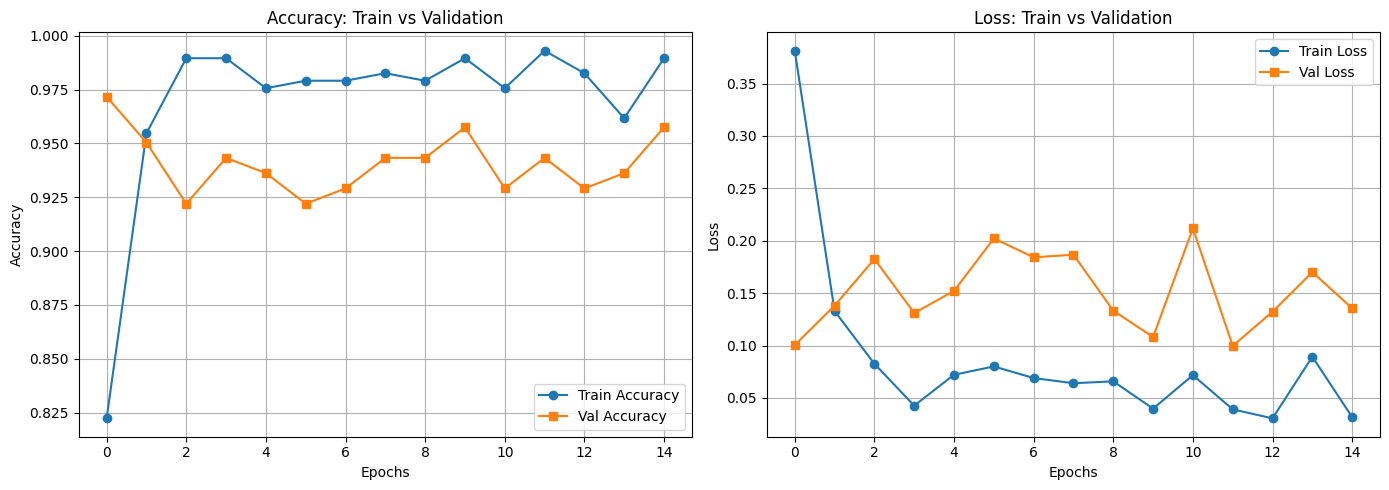

Graphique sauvegardé: mlp_training_curves.png


In [6]:
import matplotlib.pyplot as plt

# Extraction des métriques
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Création des graphiques
plt.figure(figsize=(14, 5))

# Courbe d'Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Val Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy: Train vs Validation')
plt.legend()
plt.grid(True)

# Courbe de Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Val Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss: Train vs Validation')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('mlp_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graphique sauvegardé: mlp_training_curves.png")